In [1]:
import pandas as pd
from silhouette_upper_bound import upper_bound, upper_bound_samples, upper_bound_macro_silhouette
import numpy as np
import matplotlib.pyplot as plt 
import pickle
from sklearn.metrics import silhouette_score, adjusted_rand_score, silhouette_samples, adjusted_mutual_info_score
from collections import Counter
import kmedoids
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import squareform, pdist
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from tqdm import tqdm
from pathlib import Path
from scipy.io import arff
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

In [2]:
def _macro_averaged_silhouette(dissimilarity_matrix, labels):

    silhouette_scores = silhouette_samples(
        X=dissimilarity_matrix, labels=labels, metric="precomputed"
    )

    mac_silh = []

    for cluster_id in np.unique(labels):
        scores = silhouette_scores[labels == cluster_id]

        mac_silh.append(np.mean(scores))

    return np.mean(mac_silh)

In [3]:
def save_results(path, diss_matrix, k_range = range(2, 16), random_state = 42):

    if Path(path).exists():
        print("Path exists. Aborting.")
        return None 

    results = {}

    list_n_clusters = []
    list_cluster_labels = []
    list_cluster_sizes = []
    list_min_cluster_size = []
    list_silh_samples = []
    list_asw = []
    list_ub_asw = []
    list_ub_asw_min_cluster_size = []
    list_macro_silhouette = []
    list_ub_macro = []

    for k in tqdm(k_range):

        # cluster labels
        cluster_labels = (kmedoids.pamsil(diss=diss_matrix, medoids=k, random_state=random_state).labels + 1)

        # cluster sizes
        cluster_sizes = list(Counter(cluster_labels).values())
        min_cluster_size = min(cluster_sizes)

        # silhouette samples 
        silh_samples = silhouette_samples(X=diss_matrix, labels=cluster_labels, metric='precomputed')

        # ASW 
        asw = np.mean(silh_samples)
        ub_asw = upper_bound(diss_matrix)
        ub_asw_min_cluster_size = upper_bound(diss_matrix, kappa=min_cluster_size)

        # Macro silhouette 
        macro_silhouette = _macro_averaged_silhouette(diss_matrix, cluster_labels)
        ub_macro = upper_bound_macro_silhouette(diss_matrix, cluster_sizes)

        list_n_clusters.append(k)
        list_cluster_labels.append(cluster_labels)
        list_cluster_sizes.append(cluster_sizes)
        list_min_cluster_size.append(min_cluster_size)
        list_silh_samples.append(silh_samples)
        list_asw.append(asw)
        list_ub_asw.append(ub_asw)
        list_ub_asw_min_cluster_size.append(ub_asw_min_cluster_size)
        list_macro_silhouette.append(macro_silhouette)
        list_ub_macro.append(ub_macro)
    
    results = {
        "n_clusters": list_n_clusters,
        "cluster_labels": list_cluster_labels,
        "cluster_sizes": list_cluster_sizes,
        "min_cluster_size": list_min_cluster_size,
        "silh_samples": list_silh_samples,
        "asw": list_asw,
        "ub_asw": list_ub_asw,
        "ub_asw_min_cluster_size": list_ub_asw_min_cluster_size,
        "macro_silhouette": list_macro_silhouette,
        "ub_macro": list_ub_macro
    }
    
    # Save to pickle 
    pd.DataFrame.from_dict(results).to_pickle(path)


In [4]:
def plot_asw_vs_k(results):
    # Put data into a tidy DataFrame for seaborn
    df = pd.DataFrame(
        {
            "K": results["n_clusters"],
            "PAMSIL ASW": results["asw"],
            "PAMSIL Macro Silhouette": results["macro_silhouette"],
            "ASW upper bound (constrained solution space)": results["ub_asw_min_cluster_size"],
            "Macro Silhouette upper bound (constrained solution space)": results["ub_macro"]
        }
    )

    # Melt the DataFrame for seaborn
    df_melted = df.melt(
        id_vars="K",
        value_vars=[
            "PAMSIL ASW",
            "PAMSIL Macro Silhouette",
            "ASW upper bound (constrained solution space)",
            "Macro Silhouette upper bound (constrained solution space)"
        ],
        var_name="Method",
        value_name=" ",
    )

    # Plot
    sns.set_theme(style="whitegrid", context="talk", rc={"lines.markersize": 7})

    plt.figure(figsize=(8, 6))
    ax = sns.lineplot(
        data=df_melted,
        x="K",
        y=" ",
        hue="Method",
        style="Method",
        markers=["o", "o", "X", "X"],
        linewidth=1.5,
    )

    # Reference lines
    plt.axhline(
        y=results["ub_asw"].values[0], color="black", linestyle="--", linewidth=1.5, label=f"ASW upper bound"
    )

    # Adjust axes
    ax.xaxis.set_major_locator(MultipleLocator(1)) 
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    plt.ylim(0.0, 1.0)

    # Titles and labels
    plt.xlabel("Number of clusters (K)", fontsize=14)
    plt.legend(fontsize=12, title_fontsize=13, loc="best")

    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def results_stats(results, n_classes, labels = None):

    # use "true" number of clusterss
    n_classes_results = results[results["n_clusters"] == n_classes]

    min_cluster_size = n_classes_results["min_cluster_size"].values[0]
    print(f"Min cluster size: {min_cluster_size}")

    asw = n_classes_results["asw"].values[0]
    ub_asw = n_classes_results["ub_asw"].values[0]
    wcre = (ub_asw - asw) / ub_asw

    if labels is not None:
        ari = adjusted_rand_score(labels, n_classes_results["cluster_labels"].values[0])
        ami = adjusted_mutual_info_score(labels, n_classes_results["cluster_labels"].values[0])

        print(f"Adjusted Rand Index vs. true labels: {ari:.3f}")
        print(f"Adjusted Mutual Info vs. true labels: {ami:.3f}")
        
    print(f"ASW: {asw:.3f}")
    print(f"UB: {ub_asw:.3f}")
    print(f"wcre: {wcre:.3f}")

    ub_asw_adjusted = n_classes_results["ub_asw_min_cluster_size"].values[0]
    wcre_adjusted = (ub_asw_adjusted - asw) / ub_asw_adjusted

    print(f"UB adjusted: {ub_asw_adjusted:.3f}")
    print(f"wcre adjsuted: {wcre_adjusted:.3f}")

    return None 
    


# Ceramic shards 
* Scaling: Standard scaler
* Outlier removal: None
* n_samples: 88
* n_features: 17
* n_classes: 2
* Access to labels: yes
* Metric: L1 distance
* Method: Kmedoids

In [6]:
# Load dataset
df = pd.read_csv("data/ceramic/data.csv")

In [7]:
# Select only numeric chemical composition columns
y = df["Part"]
X = df.drop(columns=["Ceramic Name", "Part"])
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape 

(88, 17)

In [8]:
print(X_scaled.shape)
np.save("arrays/ceramic.npy", X_scaled)
D = squareform(pdist(X_scaled, metric="cityblock"))
upper_bound(D)

(88, 17)


np.float64(0.6205462386943069)

In [9]:
# save results 
save_results(path = "results/ceramic.pkl", diss_matrix=D)

Path exists. Aborting.


In [10]:
# load results 
results = pd.read_pickle("results/ceramic.pkl") 

In [11]:
results_stats(results, 2, y)

Min cluster size: 44
Adjusted Rand Index vs. true labels: 1.000
Adjusted Mutual Info vs. true labels: 1.000
ASW: 0.358
UB: 0.621
wcre: 0.423
UB adjusted: 0.403
wcre adjsuted: 0.112


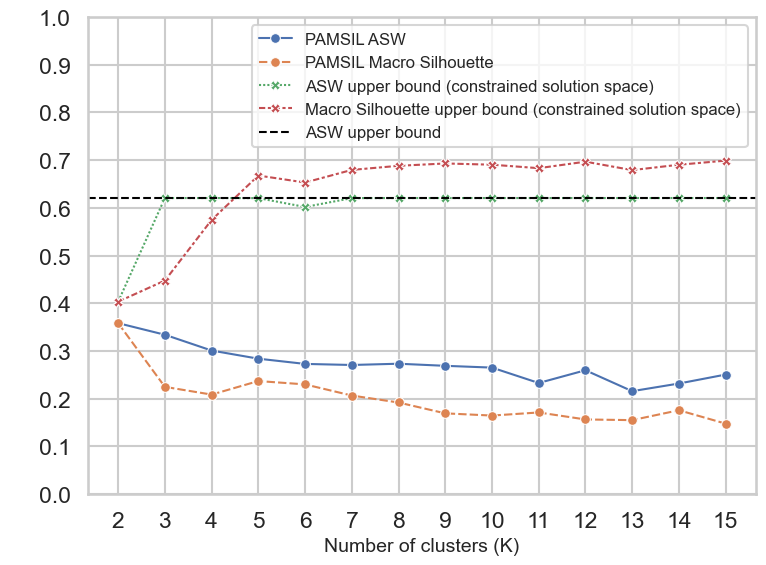

In [12]:
plot_asw_vs_k(pd.read_pickle("results/ceramic.pkl") )

# Gene expressions
* Scaling: None
* Outlier removal: None
* n_samples: 801
* n_features: 20531
* n_classes: 5
* Access to labels: no
* Metric: L2 distance
* Method: Kmedoids

In [13]:
df = pd.read_csv("data/rna/data.csv")

In [14]:
data = df.select_dtypes(include="number")

print(f"Data shape: {data.shape}")

X = data.to_numpy()

Data shape: (801, 20531)


In [15]:
print(X.shape)
np.save("arrays/rna.npy", X)
D = squareform(pdist(X, metric="euclidean"))
upper_bound(D)

(801, 20531)


np.float64(0.41947765108572166)

In [16]:
# save results 
save_results(path = "results/rna.pkl", diss_matrix=D)

Path exists. Aborting.


In [17]:
results_stats(pd.read_pickle("results/rna.pkl"), 5)

Min cluster size: 77
ASW: 0.225
UB: 0.419
wcre: 0.464
UB adjusted: 0.323
wcre adjsuted: 0.303


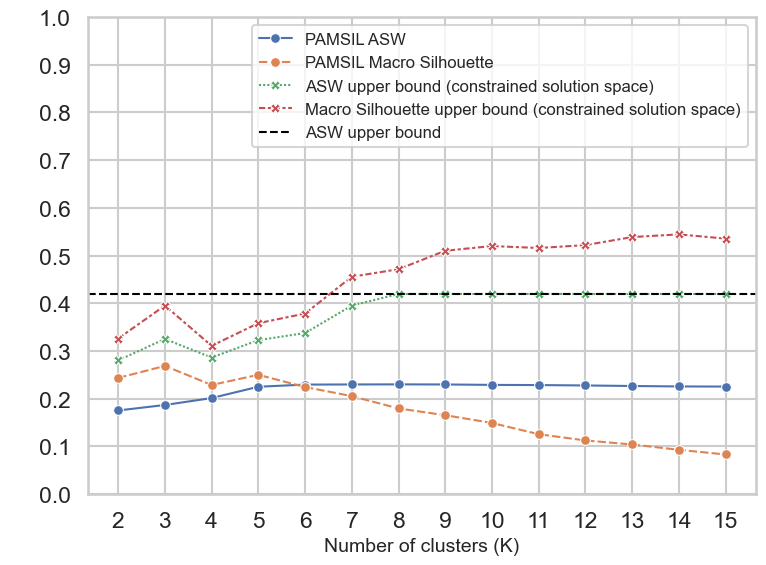

In [18]:
plot_asw_vs_k(pd.read_pickle("results/rna.pkl"))

# Wine 
* Scaling: Standard Scaler
* Outlier removal: None
* n_samples: 
* n_features: 
* n_classes: 3
* Access to labels: yes
* Metric: L1 distance
* Method: Kmedoids

In [19]:
data, meta = arff.loadarff("data/wine/wine.arff")
df = pd.DataFrame(data)

In [20]:
# Frst column is label
y = df.iloc[:, 0].astype(str).to_numpy()
X = df.iloc[:, 1:].to_numpy()

In [21]:
X = StandardScaler().fit_transform(X)

In [22]:
print(X.shape)
np.save("arrays/wine.npy", X)
D = squareform(pdist(X, metric="cityblock"))
upper_bound(D)

(178, 13)


np.float64(0.6492611711765902)

In [23]:
# save results 
save_results(path = "results/wine.pkl", diss_matrix=D)

Path exists. Aborting.


In [24]:
results_stats(pd.read_pickle("results/wine.pkl"), 3, y)

Min cluster size: 53
Adjusted Rand Index vs. true labels: 0.884
Adjusted Mutual Info vs. true labels: 0.864
ASW: 0.315
UB: 0.649
wcre: 0.514
UB adjusted: 0.450
wcre adjsuted: 0.298


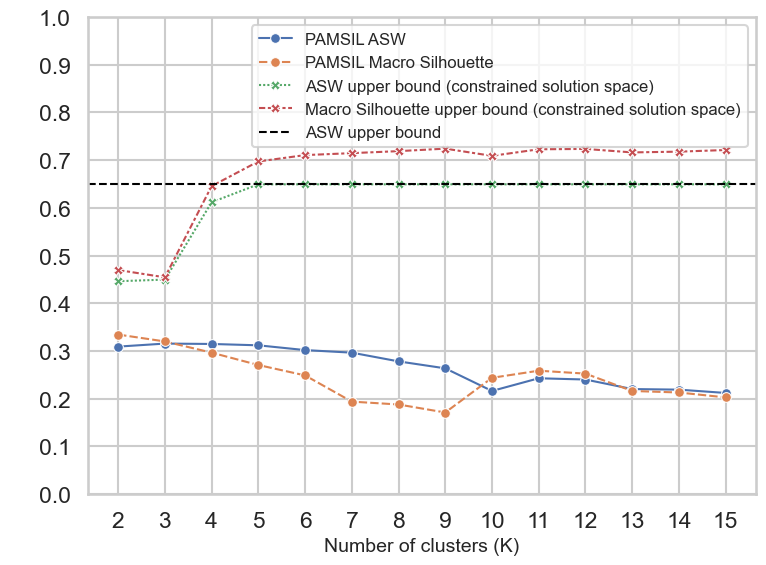

In [25]:
plot_asw_vs_k(pd.read_pickle("results/wine.pkl"))

# WDBC
* Scaling: Standard Scaler
* Outlier removal: Yes
* n_samples: 
* n_features: 
* n_classes: 2
* Access to labels: yes
* Metric: L2 distance
* Method: Kmedoids

In [26]:
# --- 1. Load the ARFF file ---
data, meta = arff.loadarff("data/wdbc/wdbc.arff")

# --- 2. Convert to DataFrame ---
df = pd.DataFrame(data)

# --- 3. Decode bytes (ARFF nominal fields are byte strings) ---
df = df.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)

# --- 4. Drop ID column (not a feature) ---
df = df.drop(columns=["IDNumber"])

# --- 5. Split features and class label ---
X = df.drop(columns=["class"]).astype(float)
y = df["class"]

# --- 6. Standardize features for Euclidean distance ---
# StandardScaler makes all features comparable (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/var/folders/40/l50vx_fn2nd9hv4y_ssvkhn80000gn/T/ipykernel_34261/3586431331.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)


In [27]:
# --- 6. Detect outliers via z-score ---
z_scores = np.abs((X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0))
threshold = 2.0  # typically 3 standard deviations from mean

mask = (z_scores < threshold).all(axis=1)
X_clean = X_scaled[mask]
y_clean = y[mask]

print(f"Removed {(~mask).sum()} outliers out of {len(mask)} ({100*(~mask).sum()/len(mask):.2f}%)")

Removed 187 outliers out of 569 (32.86%)


In [28]:
print(X_clean.shape)
np.save("arrays/wdbc.npy", X_clean)
D = squareform(pdist(X_clean, metric="euclidean"))
upper_bound(D)

(382, 30)


np.float64(0.6208918944409422)

In [29]:
# save results 
save_results(path = "results/wdbc.pkl", diss_matrix=D)

Path exists. Aborting.


In [30]:
results_stats(pd.read_pickle("results/wdbc.pkl"), 2, y_clean)

Min cluster size: 46
Adjusted Rand Index vs. true labels: 0.427
Adjusted Mutual Info vs. true labels: 0.386
ASW: 0.348
UB: 0.621
wcre: 0.440
UB adjusted: 0.455
wcre adjsuted: 0.236


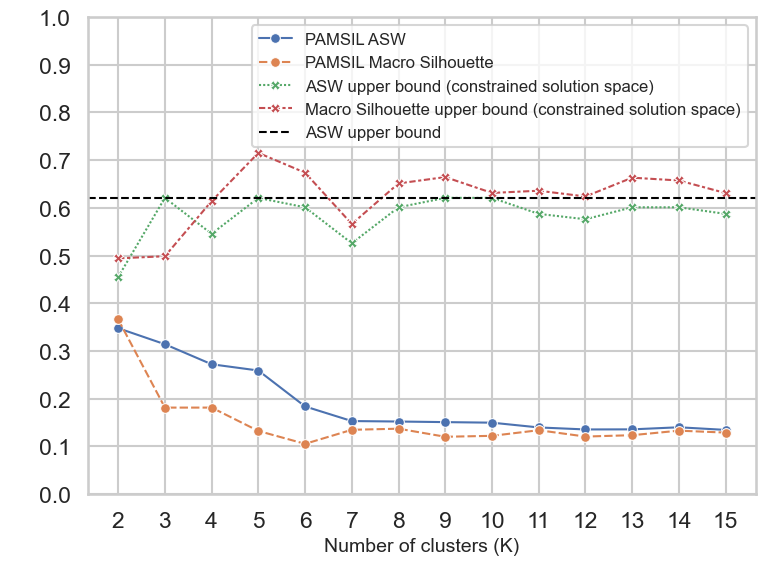

In [31]:
plot_asw_vs_k(pd.read_pickle("results/wdbc.pkl") )

# Customers
* Scaling: Robust Scaler
* Outlier removal: Yes
* n_samples: 378
* n_features: 7
* n_classes: 2
* Access to labels: yes
* Metric: Cosine
* Method: Kmedoids

In [32]:
df = pd.read_csv("data/customers/data.csv")
y = df["Channel"]

In [33]:
df = df.drop(columns=["Channel"])
X = df.to_numpy()
X_clean = RobustScaler().fit_transform(X)

In [34]:
z_scores = np.abs(stats.zscore(X_clean))
mask = (z_scores < 2).all(axis=1)  # keep rows where all features have z < 3
X_clean = X_clean[mask]
y_clean = y[mask]

In [35]:
print(X_clean.shape)
np.save("arrays/customers.npy", X_clean)
D = squareform(pdist(X_clean, metric="cosine"))
upper_bound(D)

(378, 7)


np.float64(0.9508482863980949)

In [36]:
# save results 
save_results(path = "results/customers.pkl", diss_matrix=D)

Path exists. Aborting.


In [37]:
results_stats(pd.read_pickle("results/customers.pkl"), 2, y_clean)

Min cluster size: 170
Adjusted Rand Index vs. true labels: 0.394
Adjusted Mutual Info vs. true labels: 0.366
ASW: 0.400
UB: 0.951
wcre: 0.579
UB adjusted: 0.574
wcre adjsuted: 0.303


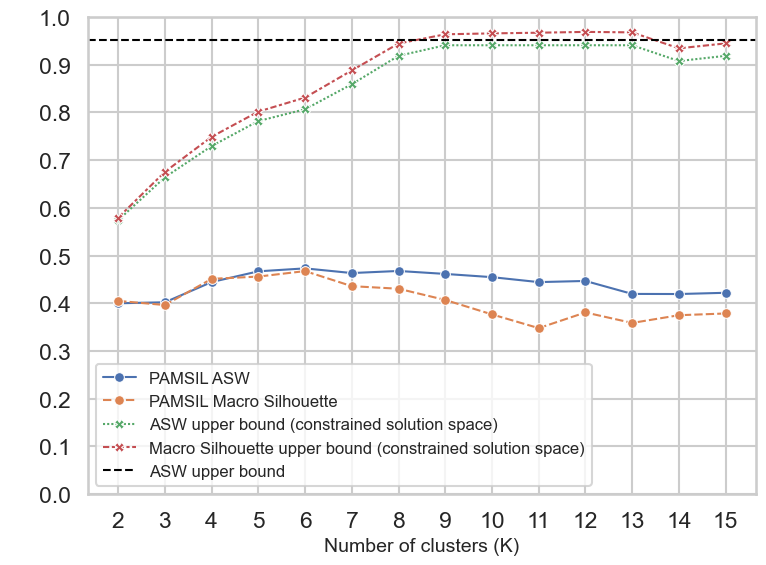

In [38]:
plot_asw_vs_k(pd.read_pickle("results/customers.pkl") )

# Dermatology
* Scaling: Standard Scaler
* Outlier removal: No
* n_samples: 
* n_features: 
* n_classes: 6
* Access to labels: yes
* Metric: Cosine
* Method: Kmedoids

In [39]:
# --- 1. Load the ARFF file ---
data, meta = arff.loadarff("data/dermatology/dermatology.arff")

# --- 2. Convert to DataFrame ---
df = pd.DataFrame(data)

# --- 3. Decode byte strings (ARFF nominal data often comes as bytes) ---
df = df.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)

# --- 4. Replace missing values ('?') and convert to numeric ---
df = df.replace('?', pd.NA)
df = df.astype(float)

# --- 5. Separate features and labels ---
X = df.drop(columns=["class"])
y = df["class"]

# --- 6. Impute missing Age values ---
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# --- 7. Standardize and then normalize for cosine distance ---
# StandardScaler: centers & scales features
# normalize(): scales each sample to unit norm → cosine similarity becomes dot product
X_scaled = StandardScaler().fit_transform(X_imputed)
X_cosine = normalize(X_scaled, norm="l2")

/var/folders/40/l50vx_fn2nd9hv4y_ssvkhn80000gn/T/ipykernel_34261/1157245614.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)


In [40]:
print(X_cosine.shape)
np.save("arrays/dermatology.npy", X_cosine)
D = squareform(pdist(X_cosine, metric="cosine"))
upper_bound(D)

(366, 34)


np.float64(0.83590498779012)

In [41]:
# save results 
save_results(path = "results/dermatology.pkl", diss_matrix=D)

Path exists. Aborting.


In [42]:
results_stats(pd.read_pickle("results/dermatology.pkl"), 6, y)

Min cluster size: 21
Adjusted Rand Index vs. true labels: 0.850
Adjusted Mutual Info vs. true labels: 0.875
ASW: 0.455
UB: 0.836
wcre: 0.456
UB adjusted: 0.704
wcre adjsuted: 0.354


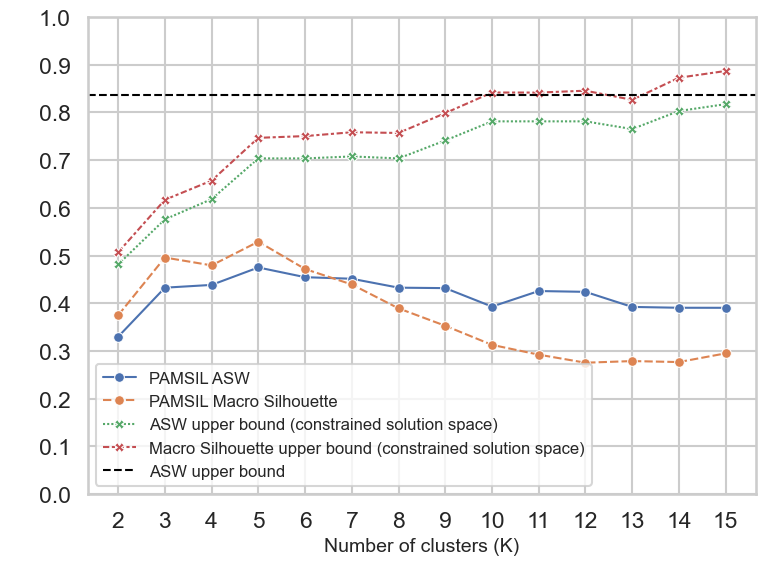

In [43]:
plot_asw_vs_k(pd.read_pickle("results/dermatology.pkl") )

# Optdigits
* Scaling: Standard Scaler
* Outlier removal: Yes
* n_samples: 
* n_features: 
* n_classes: 10
* Access to labels: yes
* Metric: Euclidean
* Method: Kmedoids

In [44]:
# Load training and test data
train_df = pd.read_csv("data/optdigits/optdigits.tra", header=None)
test_df = pd.read_csv("data/optdigits/optdigits.tes", header=None)

# Combine for clustering (drop labels if you want unsupervised learning)
df = pd.concat([train_df, test_df], ignore_index=True)

# Separate features and labels
X = df.iloc[:, :-1]  # 64 features
y = df.iloc[:, -1]   # labels 0-9

In [45]:
X = StandardScaler().fit_transform(X)  

In [46]:
mean = X.mean(axis=0)
std = X.std(axis=0)
std[std == 0] = 1  # avoid division by zero

z_scores = np.abs((X - mean) / std)
mask = (z_scores < 2.0).all(axis=1)
X = X[mask]
y = y[mask]

In [47]:
print(X.shape)
np.save("arrays/optdigits.npy", X)
D = squareform(pdist(X, metric="euclidean"))
upper_bound(D)

(2296, 64)


np.float64(0.619718300666876)

In [48]:
# save results 
save_results(path = "results/optdigits.pkl", diss_matrix=D)

Path exists. Aborting.


In [49]:
results_stats(pd.read_pickle("results/optdigits.pkl"), 10, y)

Min cluster size: 50
Adjusted Rand Index vs. true labels: 0.803
Adjusted Mutual Info vs. true labels: 0.819
ASW: 0.180
UB: 0.620
wcre: 0.709
UB adjusted: 0.463
wcre adjsuted: 0.611


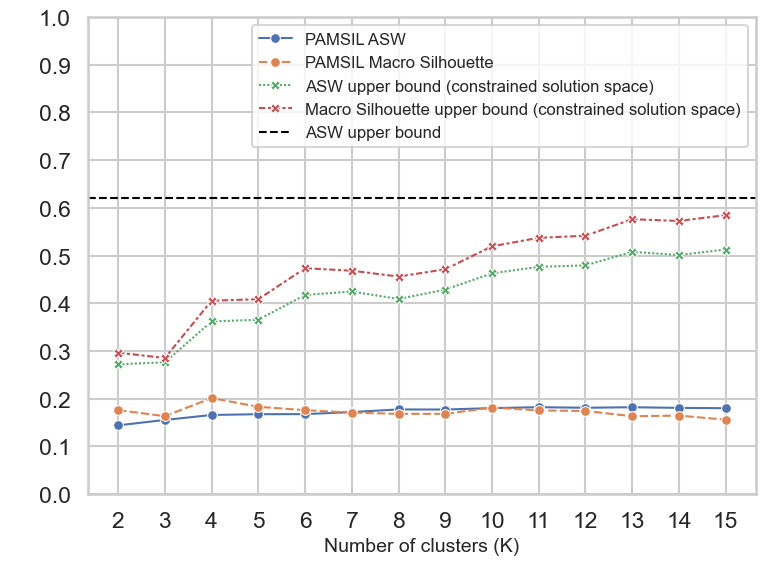

In [50]:
plot_asw_vs_k(pd.read_pickle("results/optdigits.pkl") )

# Heart statlog
* Scaling: Standard Scaler
* Outlier removal: Yes
* n_samples: 
* n_features: 13
* n_classes: 2
* Access to labels: yes
* Metric: Euclidean
* Method: Kmedoids

In [51]:
data, meta = arff.loadarff("data/heartstatlog/heart-statlog.arff")

# --- 2. Convert to DataFrame ---
df = pd.DataFrame(data)

In [52]:
y = df["class"]
y = y.str.decode('utf-8')
# Map to integers
y = y.map({'absent': 0, 'present': 1})

In [53]:
# Drop the target
X = df.drop(columns=["class"])

# One-hot encode nominal columns
nominal_cols = ["chest", "resting_electrocardiographic_results", "slope", "thal"]
X = pd.get_dummies(X, columns=nominal_cols, drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
# --- 6. Detect outliers via z-score ---
z_scores = np.abs((X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0))
threshold = 3.0  # typically 3 standard deviations from mean

mask = (z_scores < threshold).all(axis=1)
X_clean = X_scaled[mask]
y_clean = y[mask]

print(f"Removed {(~mask).sum()} outliers out of {len(mask)} ({100*(~mask).sum()/len(mask):.2f}%)")

Removed 39 outliers out of 270 (14.44%)


In [55]:
print(X_clean.shape) # > 13 features due to one-hot encoding
np.save("arrays/heart_statlog.npy", X_clean)
D = squareform(pdist(X_clean, metric="euclidean"))
upper_bound(D)

(231, 18)


np.float64(0.6003930865824887)

In [56]:
# save results 
save_results(path = "results/heart_statlog.pkl", diss_matrix=D)

Path exists. Aborting.


In [57]:
results_stats(pd.read_pickle("results/heart_statlog.pkl"), 2, y_clean)

Min cluster size: 83
Adjusted Rand Index vs. true labels: 0.447
Adjusted Mutual Info vs. true labels: 0.349
ASW: 0.161
UB: 0.600
wcre: 0.731
UB adjusted: 0.279
wcre adjsuted: 0.422


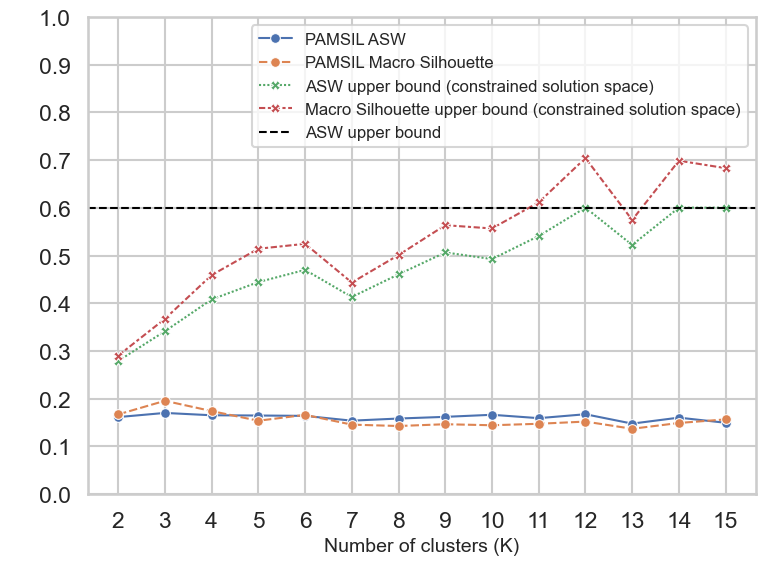

In [58]:
plot_asw_vs_k(pd.read_pickle("results/heart_statlog.pkl") )